# ARIMA MODEL TRAINING
---

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from helpers import (
    find_best_sarima_cached,
    find_missing_date_ranges,
    present_base_dataset,
    evaluate_predictions,
    compare_prediction,
)
from enums import (
    DatasetColumns,
    WeatherDatasetColumns
)

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA

## Data Preparation
---


In [6]:
#  Constants
FILE_NAME = "dataset.csv"
WEATHER_DATASET = "dataset_weather.csv"

In [7]:
# Load data
original_data = pd.read_csv(
    FILE_NAME,
    parse_dates=[DatasetColumns.STATISTICAL_PERIOD.value],
    index_col=DatasetColumns.STATISTICAL_PERIOD.value,
)

weather_data = pd.read_csv(
    WEATHER_DATASET,
    parse_dates=[WeatherDatasetColumns.DATETIME.value],
    index_col=WeatherDatasetColumns.DATETIME.value,
).asfreq("h")

weather_features = [
    WeatherDatasetColumns.TEMPERATURE_C.value,
    WeatherDatasetColumns.HUMIDITY_PERCENT.value,
]

In [8]:
# Find missing date ranges
gap_start, gap_end = find_missing_date_ranges(
    original_data, DatasetColumns.STATISTICAL_PERIOD.value
)
gap_dates = pd.date_range(start=gap_start, end=gap_end, freq="h")

In [9]:
# Split data and Handling Null
pre_gap_data = original_data[original_data.index < gap_start].asfreq("h")
pre_gap_train_size = int(len(pre_gap_data) * 0.8)
pre_gap_train = pre_gap_data.iloc[
    :pre_gap_train_size
].copy() 
pre_gap_test = pre_gap_data.iloc[pre_gap_train_size:]


post_gap_data = original_data[original_data.index >= gap_end].asfreq("h")

pre_weather_data = weather_data[weather_data.index < gap_start].bfill()
gap_weather_data = weather_data.reindex(gap_dates).ffill()
post_weather_data = weather_data[weather_data.index >= gap_end].bfill()

pre_gap_train.loc[:, DatasetColumns.PV_YIELD.value] = pre_gap_train[
    DatasetColumns.PV_YIELD.value
].interpolate(method="linear")

pre_weather_data = pre_weather_data.drop(
    pre_weather_data.index.difference(pre_gap_data.index)
)

## `pre_gap_data` training model
---

In [ ]:
# Tune hyperparameters
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
seasonal_period = 24 

best_params, best_aic = find_best_sarima_cached(
    pre_gap_train[DatasetColumns.PV_YIELD.value],
    seasonal_period,
    p,
    d,
    q,
    P,
    D,
    Q,
)

(order_params, seasonal_params) = best_params
print(f"Best Parameters: {best_params}, AIC: {best_aic}")

In [ ]:
# Train without exocgenous variables and seasonal components
def train_arima_model():
    arima_model = ARIMA(
        pre_gap_train[DatasetColumns.PV_YIELD.value],
        order=order_params,  
        enforce_stationarity=False,
        enforce_invertibility=False,
    )
    arima_result = arima_model.fit()
    preds = arima_result.predict(start=pre_gap_test.index[0], end=pre_gap_test.index[-1])

    evaluate_predictions(pre_gap_test[DatasetColumns.PV_YIELD.value], preds)    
    
    compare_prediction(
        "ARIMA Predictions vs Actual",
        pre_gap_train[DatasetColumns.PV_YIELD.value],
        pre_gap_test[DatasetColumns.PV_YIELD.value],
        preds,
    )
    
train_arima_model()

In [ ]:
# Train without exocgenous variables
def train_sarima_model():
    sarimax_model = SARIMAX(
        pre_gap_train[DatasetColumns.PV_YIELD.value],
        order=order_params,
        seasonal_order=seasonal_params + (seasonal_period,),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    sarimax_result = sarimax_model.fit()
    preds = sarimax_result.predict(
        start=pre_gap_test.index[0], end=pre_gap_test.index[-1]
    )

    evaluate_predictions(pre_gap_test[DatasetColumns.PV_YIELD.value], preds)

    compare_prediction(
        "SARIMA without Exogenous Predictions vs Actual",
        pre_gap_train[DatasetColumns.PV_YIELD.value],
        pre_gap_test[DatasetColumns.PV_YIELD.value],
        preds,
    )


train_sarima_model()

In [ ]:
# Train with Exogenous Variables
def train_sarima_with_exogenous():
    merged_train = pre_gap_train.merge(
        pre_weather_data[weather_features],
        left_index=True,
        right_index=True,
        how="inner",
    )
    merged_test = pre_gap_test.merge(
        pre_weather_data[weather_features],
        left_index=True,
        right_index=True,
        how="inner",
    )

    exog_train = merged_train[weather_features].ffill()
    exog_test = merged_test[weather_features].ffill()

    sarimax_model_exog = SARIMAX(
        merged_train[DatasetColumns.PV_YIELD.value],
        exog=exog_train,
        order=order_params,
        seasonal_order=seasonal_params + (seasonal_period,),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    sarimax_result_exog = sarimax_model_exog.fit()

    preds_exog = sarimax_result_exog.predict(
        start=merged_test.index[0],
        end=merged_test.index[-1],
        exog=exog_test,
    )

    evaluate_predictions(merged_test[DatasetColumns.PV_YIELD.value], preds_exog)

    compare_prediction(
        "SARIMA with Exogenous Predictions vs Actual",
        merged_train[DatasetColumns.PV_YIELD.value],
        merged_test[DatasetColumns.PV_YIELD.value],
        preds_exog,
    )
    return sarimax_result_exog


# Train the model and retrieve the results
trained_model = train_sarima_with_exogenous()

In [ ]:
# Train with Exogenous Variables using Time-Series Cross-Validation
def train_sarima_with_exogenous_cv():
    merged_data = pre_gap_train.merge(
        pre_weather_data[weather_features],
        left_index=True,
        right_index=True,
        how="inner",
    )
    
    exog_data = merged_data[weather_features]
    ts_cv = TimeSeriesSplit(n_splits=5) 
    
    model = None

    for i, (train_idx, test_idx) in enumerate(ts_cv.split(merged_data)):
        train_data, test_data = merged_data.iloc[train_idx], merged_data.iloc[test_idx]
        exog_train, exog_test = exog_data.iloc[train_idx], exog_data.iloc[test_idx]

        sarimax_model_exog = SARIMAX(
            train_data[DatasetColumns.PV_YIELD.value],
            exog=exog_train,
            order=order_params,
            seasonal_order=seasonal_params + (seasonal_period,),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )

        sarimax_result_exog = sarimax_model_exog.fit()

        preds_exog = sarimax_result_exog.predict(
            start=test_data.index[0],
            end=test_data.index[-1],
            exog=exog_test,
        )

        if i == ts_cv.n_splits - 1:
            evaluate_predictions(test_data[DatasetColumns.PV_YIELD.value], preds_exog)
            compare_prediction(
                f"SARIMA with Exogenous Predictions vs Actual",
                train_data[DatasetColumns.PV_YIELD.value],
                test_data[DatasetColumns.PV_YIELD.value],
                preds_exog,
            )

            model = sarimax_result_exog

    return model

trained_model_cv = train_sarima_with_exogenous_cv()

In [70]:
# Combine Gap Prediction
exog_gap = gap_weather_data[weather_features]
gap_predictions = trained_model_cv.forecast(steps=len(gap_dates), exog=exog_gap)
gap_predictions = gap_predictions.clip(lower=0)
gap_predictions_df = gap_predictions.to_frame(name=DatasetColumns.PV_YIELD.value)
gap_predictions_df.index = gap_dates

combined_data = pd.concat([pre_gap_data, gap_predictions_df, post_gap_data]).asfreq("h")
combined_data.to_csv("combined_data.csv", index=True)
combined_data_train_size = int(len(combined_data) * 0.8)
combined_data_train = combined_data.iloc[:combined_data_train_size].copy()
combined_data_test = combined_data.iloc[combined_data_train_size:]

## Train
---

In [68]:
# Tune hyperparameters
p = d = q = range(0, 3)
P = D = Q = range(0, 2)
seasonal_period = 24

best_params, best_aic = find_best_sarima_cached(
    combined_data[DatasetColumns.PV_YIELD.value],
    seasonal_period,
    p,
    d,
    q,
    P,
    D,
    Q,
    "sarima_full"
)

(order_params, seasonal_params) = best_params
print(f"Best Parameters: {best_params}, AIC: {best_aic}")

Best Parameters: ((2, 0, 0), (1, 1, 1)), AIC: -11047.353446318873


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.93472D-01    |proj g|=  1.51775D+00


 This problem is unconstrained.



At iterate    5    f= -5.18358D-01    |proj g|=  3.65345D-01

At iterate   10    f= -5.48223D-01    |proj g|=  3.09721D-01

At iterate   15    f= -5.55677D-01    |proj g|=  6.87084D-02

At iterate   20    f= -5.56926D-01    |proj g|=  1.59884D-02

At iterate   25    f= -5.56999D-01    |proj g|=  1.21699D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     36      1     0     0   8.459D-05  -5.570D-01
  F = -0.55699949234560631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
10% of Mean Value (Target MAE/RMSE): 0.02654978165938865
Mean Absolute Error (MAE): 0.09343260596556406
Mean Squa

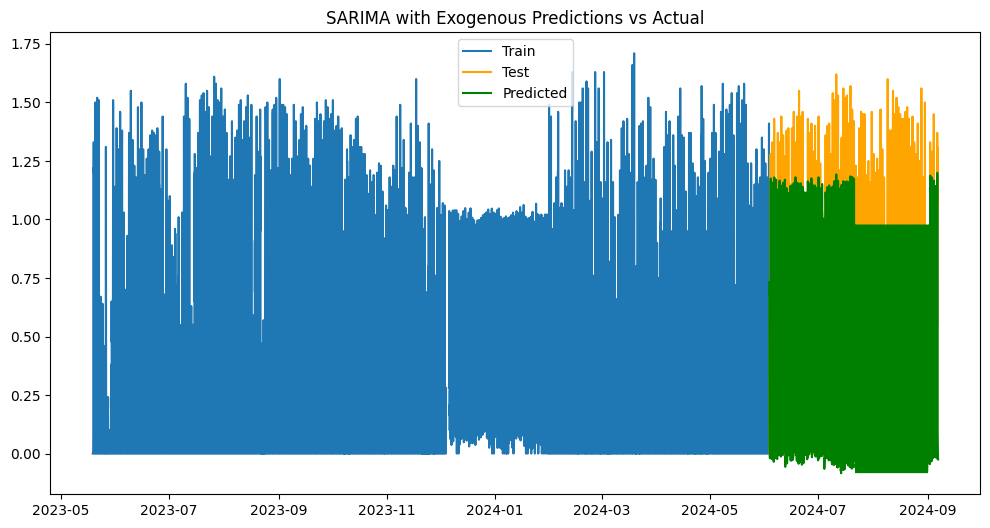

In [71]:
# Train with Exogenous Variables
def full_train_sarima_with_exogenous():
    merged_train = combined_data_train.merge(
        weather_data[weather_features],
        left_index=True,
        right_index=True,
        how="inner",
    )
    merged_test = combined_data_test.merge(
        weather_data[weather_features],
        left_index=True,
        right_index=True,
        how="inner",
    )

    exog_train = merged_train[weather_features].ffill()
    exog_test = merged_test[weather_features].ffill()

    sarimax_model_exog = SARIMAX(
        merged_train[DatasetColumns.PV_YIELD.value],
        exog=exog_train,
        order=order_params,
        seasonal_order=seasonal_params + (seasonal_period,),
        enforce_stationarity=False,
        enforce_invertibility=False,
    )

    sarimax_result_exog = sarimax_model_exog.fit()
    
    preds_exog = sarimax_result_exog.predict(
        start=merged_test.index[0],
        end=merged_test.index[-1],
        exog=exog_test,
    )

    evaluate_predictions(merged_test[DatasetColumns.PV_YIELD.value], preds_exog)

    compare_prediction(
        "SARIMA with Exogenous Predictions vs Actual",
        merged_train[DatasetColumns.PV_YIELD.value],
        merged_test[DatasetColumns.PV_YIELD.value],
        preds_exog,
    )
    return sarimax_result_exog


trained_model = full_train_sarima_with_exogenous()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.07520D-01    |proj g|=  1.14820D+00

At iterate    5    f= -5.24224D-01    |proj g|=  1.24240D+00

At iterate   10    f= -5.34873D-01    |proj g|=  4.02958D-01

At iterate   15    f= -5.45349D-01    |proj g|=  1.00219D+00

At iterate   20    f= -5.64045D-01    |proj g|=  5.69586D-01

At iterate   25    f= -5.71750D-01    |proj g|=  7.47832D-02

At iterate   30    f= -5.74358D-01    |proj g|=  2.55180D-01

At iterate   35    f= -5.74521D-01    |proj g|=  1.38763D-03

At iterate   40    f= -5.74521D-01    |proj g|=  6.01274D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.43275D-01    |proj g|=  1.36940D+00

At iterate    5    f= -5.66529D-01    |proj g|=  3.33886D-01

At iterate   10    f= -6.23487D-01    |proj g|=  6.51935D-01

At iterate   15    f= -6.33155D-01    |proj g|=  1.91061D-01

At iterate   20    f= -6.34729D-01    |proj g|=  1.40131D-01

At iterate   25    f= -6.35365D-01    |proj g|=  7.66986D-02

At iterate   30    f= -6.35382D-01    |proj g|=  1.21873D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f= -6.13090D-01    |proj g|=  8.42797D-01

At iterate   10    f= -6.35962D-01    |proj g|=  5.10655D-01

At iterate   15    f= -6.47223D-01    |proj g|=  1.81945D-01

At iterate   20    f= -6.52204D-01    |proj g|=  2.81230D-02

At iterate   25    f= -6.52642D-01    |proj g|=  3.53096D-02

At iterate   30    f= -6.52673D-01    |proj g|=  2.64809D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     42      1     0     0   1.348D-03  -6.527D-01
  F = -0.65267376159950752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.01215D-01    |proj g|=  1.54003D+00

At iterate    5    f= -5.34979D-01    |proj g|=  4.25199D-01

At iterate   10    f= -5.52621D-01    |proj g|=  4.47386D-01

At iterate   15    f= -5.60766D-01    |proj g|=  9.45150D-02

At iterate   20    f= -5.66894D-01    |proj g|=  4.42512D-02

At iterate   25    f= -5.67014D-01    |proj g|=  7.48924D-02

At iterate   30    f= -5.67191D-01    |proj g|=  9.89764D-03

At iterate   35    f= -5.67195D-01    |proj g|=  6.80605D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -5.00714D-01    |proj g|=  1.55731D+00

At iterate    5    f= -5.25426D-01    |proj g|=  3.23223D-01

At iterate   10    f= -5.50312D-01    |proj g|=  2.12284D-01

At iterate   15    f= -5.62529D-01    |proj g|=  2.58802D-01

At iterate   20    f= -5.65073D-01    |proj g|=  2.86614D-02

At iterate   25    f= -5.65176D-01    |proj g|=  4.10793D-02

At iterate   30    f= -5.65286D-01    |proj g|=  2.24021D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

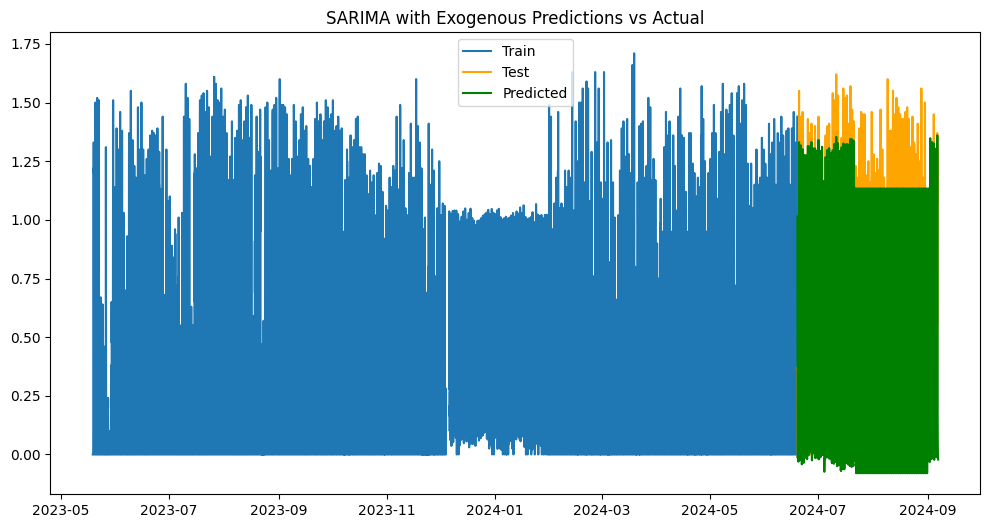

In [73]:
# Train with Exogenous Variables using Time-Series Cross-Validation
def train_sarima_with_exogenous_cv():
    merged_data = combined_data.merge(
        weather_data[weather_features],
        left_index=True,
        right_index=True,
        how="inner",
    )

    exog_data = merged_data[weather_features]
    exog_data =exog_data.ffill().bfill()
    ts_cv = TimeSeriesSplit(n_splits=5)

    model = None

    for i, (train_idx, test_idx) in enumerate(ts_cv.split(merged_data)):
        train_data, test_data = merged_data.iloc[train_idx], merged_data.iloc[test_idx]
        exog_train, exog_test = exog_data.iloc[train_idx], exog_data.iloc[test_idx]

        sarimax_model_exog = SARIMAX(
            train_data[DatasetColumns.PV_YIELD.value],
            exog=exog_train,
            order=order_params,
            seasonal_order=seasonal_params + (seasonal_period,),
            enforce_stationarity=False,
            enforce_invertibility=False,
        )

        sarimax_result_exog = sarimax_model_exog.fit()

        preds_exog = sarimax_result_exog.predict(
            start=test_data.index[0],
            end=test_data.index[-1],
            exog=exog_test,
        )

        if i == ts_cv.n_splits - 1:
            evaluate_predictions(test_data[DatasetColumns.PV_YIELD.value], preds_exog)
            compare_prediction(
                f"SARIMA with Exogenous Predictions vs Actual",
                train_data[DatasetColumns.PV_YIELD.value],
                test_data[DatasetColumns.PV_YIELD.value],
                preds_exog,
            )

            model = sarimax_result_exog

    return model


trained_model_cv = train_sarima_with_exogenous_cv()